# Stacked Bi-LSTM iter 3
Here we train for a length of 200 units
Where the change is done in creating the list of patients
Note: Here patients is list of Control subjects and patients1 is list of Parkinson patients

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

# Take my NVidia GPU into use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [3]:
files1 = glob.glob("./parkinsons/*Co*.txt")
files2 = glob.glob("./parkinsons/*Pt*.txt")
# files=files1+files2
# shuffle(files)

In [4]:
columns = ["elaps_time","L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]

In [5]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [6]:
class Patient:
    def __init__(self,input_data,y):
        self.x = input_data
        self.y = y
        self.x_scaled = input_data

In [7]:
patients=[]
un_used_data=[]

for f in files1:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+201,:]
        
        if data.shape[0] == 200:
            patients.append( Patient(data, ispark) )
        
        j=j+100

In [8]:
patients1=[]
un_used_data1=[]

for f in files2:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+201,:]
        
        if data.shape[0] == 200:
            patients1.append( Patient(data, ispark) )
        
        j=j+100

In [9]:
len(patients)

10011

In [10]:
len(patients1)


22221

In [11]:
shuffle(patients)
shuffle(patients1)

In [12]:
train = patients[:int(len(patients)*0.8)]+patients1[:int(len(patients1)*0.8)]
test = patients[int(len(patients)*0.8):]+patients1[int(len(patients1)*0.8):]

In [13]:
print(len(train))
print(len(test))

25784
6448


In [14]:
shuffle(train)
shuffle(test)

In [15]:
train_concat=[]
for p in train:
    train_concat = train_concat+[p.x]

In [16]:
data_tr = pd.concat(train_concat,ignore_index=True)

In [17]:
scaler = StandardScaler()
scaler.fit_transform(data_tr)

array([[-0.6487628 , -0.67514889, -0.64568173, ...,  1.68623587,
        -1.12452158,  0.50701034],
       [-0.6487628 , -0.67514889, -0.64568173, ...,  1.8369858 ,
        -1.12452158,  0.48846822],
       [-0.6487628 , -0.67514889, -0.64568173, ...,  1.98773573,
        -1.12452158,  0.46583593],
       ...,
       [-0.6487628 , -0.58347378, -0.59632191, ..., -0.76398129,
         1.25518893, -1.12824114],
       [-0.6487628 , -0.58347378, -0.64568173, ..., -0.76398129,
         1.23697756, -1.12824114],
       [-0.6487628 , -0.58347378, -0.64568173, ..., -0.76398129,
         1.22175611, -1.11651597]])

In [18]:
i=0
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in train:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [19]:
for obj in test:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [20]:
X_scaled_list_train=[]
Y_list_train=[]

for obj in train:
    X_scaled_list_train = X_scaled_list_train + [obj.x_scaled]
    Y_list_train = Y_list_train + [obj.y]
    
X_scaled_arr_train = np.array(X_scaled_list_train)
Y_arr_train = np.array(Y_list_train)

In [21]:
X_scaled_arr_train.shape

(25784, 200, 18)

In [22]:
Y_arr_train.shape

(25784,)

In [23]:
X_scaled_list_test=[]
Y_list_test=[]

for obj in test:
    X_scaled_list_test = X_scaled_list_test + [obj.x_scaled]
    Y_list_test = Y_list_test + [obj.y]
    
X_scaled_arr_test = np.array(X_scaled_list_test)
Y_arr_test = np.array(Y_list_test)

In [24]:
import numpy as np

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(80, dropout=0.3, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))
model.add(Bidirectional(LSTM(32, dropout=0.5,return_sequences=True)))
model.add(LSTM(24, dropout=0.2,return_sequences=True))
model.add(LSTM(12, dropout=0.2,return_sequences=False))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
opt=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    name="Adam"
    )
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/model_LSTM22_2.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)

In [ ]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=20,shuffle=True,callbacks=[early_stopping, checkpoint])

In [40]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=20,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
1032/1032 [==============================] - 84s 82ms/step - loss: 0.0200 - accuracy: 0.9954 - val_loss: 0.0197 - val_accuracy: 0.9946

Epoch 00001: val_accuracy did not improve from 0.99535
Epoch 2/500
1032/1032 [==============================] - 84s 82ms/step - loss: 0.0074 - accuracy: 0.9972 - val_loss: 0.0190 - val_accuracy: 0.9942

Epoch 00002: val_accuracy did not improve from 0.99535
Epoch 3/500
1032/1032 [==============================] - 85s 83ms/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0299 - val_accuracy: 0.9940

Epoch 00003: val_accuracy did not improve from 0.99535
Epoch 4/500
1032/1032 [==============================] - 85s 83ms/step - loss: 0.0129 - accuracy: 0.9967 - val_loss: 0.7589 - val_accuracy: 0.9306

Epoch 00004: val_accuracy did not improve from 0.99535
Epoch 5/500
1032/1032 [==============================] - 83s 80ms/step - loss: 0.0600 - accuracy: 0.9888 - val_loss: 0.0366 - val_accuracy: 0.9934

Epoch 00005: val_accuracy did not improv

In [41]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=20,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
1032/1032 [==============================] - 84s 82ms/step - loss: 0.0079 - accuracy: 0.9972 - val_loss: 0.0243 - val_accuracy: 0.9940

Epoch 00001: val_accuracy did not improve from 0.99535
Epoch 2/500
1032/1032 [==============================] - 85s 82ms/step - loss: 0.0054 - accuracy: 0.9979 - val_loss: 0.0335 - val_accuracy: 0.9930

Epoch 00002: val_accuracy did not improve from 0.99535
Epoch 3/500
1032/1032 [==============================] - 85s 83ms/step - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.0315 - val_accuracy: 0.9940

Epoch 00003: val_accuracy did not improve from 0.99535
Epoch 4/500
1032/1032 [==============================] - 84s 82ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0302 - val_accuracy: 0.9928

Epoch 00004: val_accuracy did not improve from 0.99535
Epoch 5/500
1032/1032 [==============================] - 84s 82ms/step - loss: 0.0047 - accuracy: 0.9979 - val_loss: 0.0343 - val_accuracy: 0.9940

Epoch 00005: val_accuracy did not improv

In [45]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.4,batch_size=60,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
258/258 [==============================] - 27s 103ms/step - loss: 0.0060 - accuracy: 0.9975 - val_loss: 0.0213 - val_accuracy: 0.9964

Epoch 00001: val_accuracy improved from 0.99535 to 0.99641, saving model to ./Model/model_LSTM22_2.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_2.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_2.v/assets


Epoch 2/500
258/258 [==============================] - 26s 102ms/step - loss: 0.0046 - accuracy: 0.9977 - val_loss: 0.0227 - val_accuracy: 0.9963

Epoch 00002: val_accuracy did not improve from 0.99641
Epoch 3/500
258/258 [==============================] - 26s 102ms/step - loss: 0.0125 - accuracy: 0.9970 - val_loss: 0.0203 - val_accuracy: 0.9958

Epoch 00003: val_accuracy did not improve from 0.99641
Epoch 4/500
258/258 [==============================] - 26s 99ms/step - loss: 0.0061 - accuracy: 0.9975 - val_loss: 0.0246 - val_accuracy: 0.9959

Epoch 00004: val_accuracy did not improve from 0.99641
Epoch 5/500
258/258 [==============================] - 26s 100ms/step - loss: 0.0034 - accuracy: 0.9979 - val_loss: 0.0212 - val_accuracy: 0.9962

Epoch 00005: val_accuracy did not improve from 0.99641
Epoch 6/500
258/258 [==============================] - 26s 99ms/step - loss: 0.0055 - accuracy: 0.9973 - val_loss: 0.0214 - val_accuracy: 0.9957

Epoch 00006: val_accuracy did not improve from 

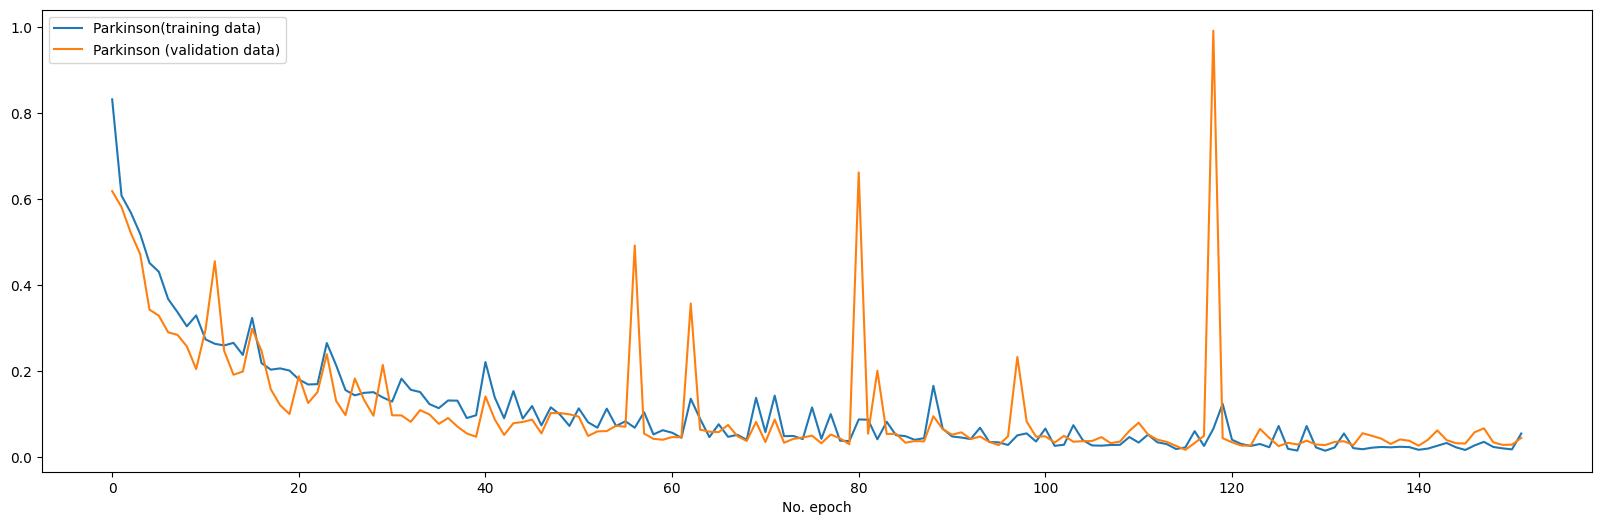

In [27]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

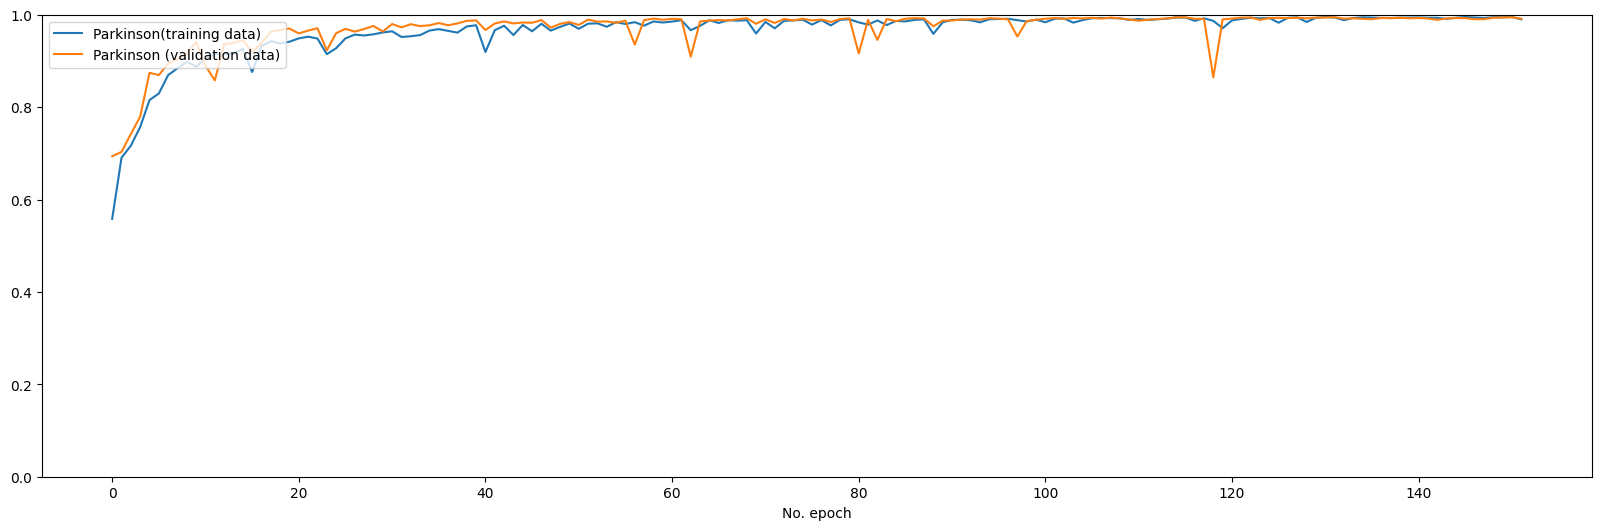

In [28]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

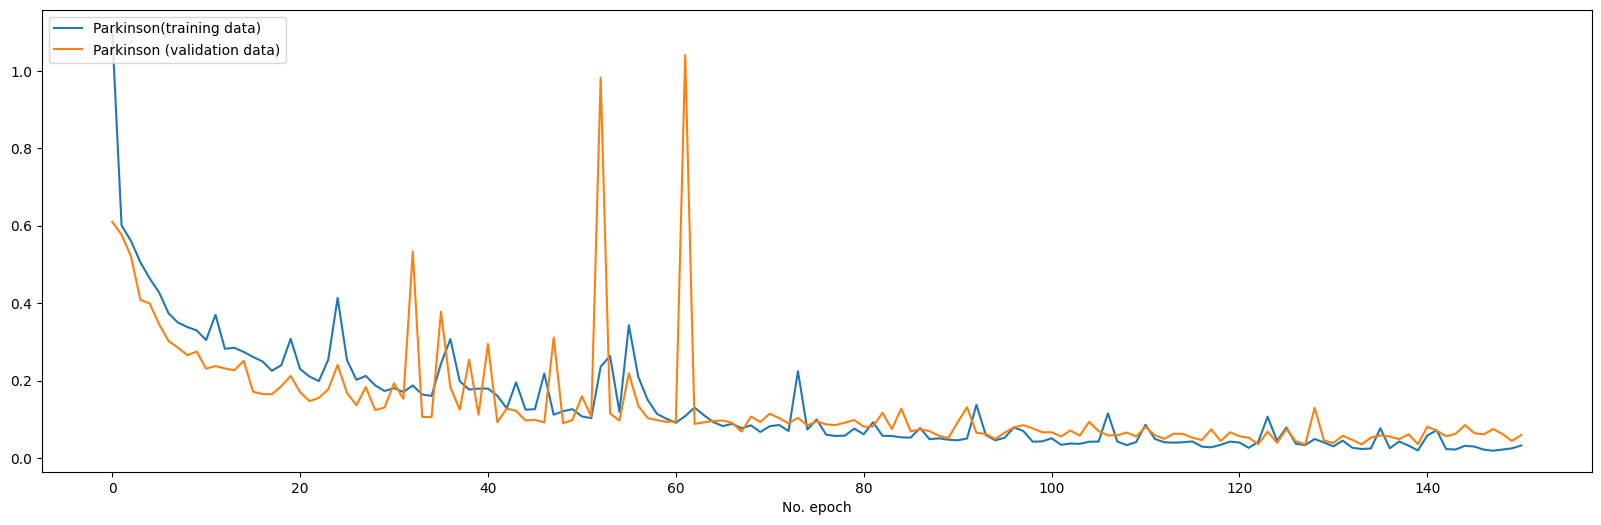

In [70]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [71]:
max(history.history['val_accuracy'])

0.9920496344566345

In [72]:
max(history.history['accuracy'])

0.9941338896751404

In [73]:
min(history.history['loss'])

0.019205331802368164

In [74]:
min(history.history['val_loss'])

0.034811072051525116

In [29]:
pdt=model.predict(X_scaled_arr_test)

In [30]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [46]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [44]:
accuracy

0.9934863523573201

In [47]:
accuracy

0.9942617866004962

In [ ]:
# classes_x=np.argmax(pdt,axis=1) 
pdt.size
classes_x = np.zeros((len(pdt)))

In [ ]:
for x in range(len(pdt)):
  if(pdt[x]>0.5):
    classes_x[x]=(1)
  else:
    classes_x[x]=(0)
#   print(x,end=" ")

In [ ]:
print(Y_arr_test.size)
classes_x.size

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x )

In [ ]:
accuracy

In [ ]:
m1=tf.keras.models.load_model('./Model/model_LSTM22.v')

In [ ]:
pdt=m1.predict(X_scaled_arr_test)

In [ ]:
for x in range(len(pdt)):
  if(pdt[x]>0.5):
    classes_x[x]=(1)
  else:
    classes_x[x]=(0)
#   print(x,end=" ")

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x )

In [ ]:
accuracy

In [83]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.4,batch_size=70,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
221/221 [==============================] - 23s 84ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0263 - val_accuracy: 0.9940

Epoch 00001: val_accuracy did not improve from 0.99409
Epoch 2/500
221/221 [==============================] - 19s 84ms/step - loss: 0.0136 - accuracy: 0.9962 - val_loss: 0.0322 - val_accuracy: 0.9937

Epoch 00002: val_accuracy did not improve from 0.99409
Epoch 3/500
221/221 [==============================] - 19s 84ms/step - loss: 0.1654 - accuracy: 0.9688 - val_loss: 0.1208 - val_accuracy: 0.9704

Epoch 00003: val_accuracy did not improve from 0.99409
Epoch 4/500
221/221 [==============================] - 19s 85ms/step - loss: 0.0924 - accuracy: 0.9752 - val_loss: 0.0677 - val_accuracy: 0.9832

Epoch 00004: val_accuracy did not improve from 0.99409
Epoch 5/500
221/221 [==============================] - 19s 85ms/step - loss: 0.0497 - accuracy: 0.9847 - val_loss: 0.0473 - val_accuracy: 0.9858

Epoch 00005: val_accuracy did not improve from 0.9

In [84]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.4,batch_size=10,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
1547/1547 [==============================] - 115s 74ms/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.0394 - val_accuracy: 0.9923

Epoch 00001: val_accuracy did not improve from 0.99409
Epoch 2/500
1547/1547 [==============================] - 115s 75ms/step - loss: 0.0139 - accuracy: 0.9957 - val_loss: 0.0444 - val_accuracy: 0.9918

Epoch 00002: val_accuracy did not improve from 0.99409
Epoch 3/500
1547/1547 [==============================] - 116s 75ms/step - loss: 0.0768 - accuracy: 0.9857 - val_loss: 0.0559 - val_accuracy: 0.9907

Epoch 00003: val_accuracy did not improve from 0.99409
Epoch 4/500
1547/1547 [==============================] - 112s 72ms/step - loss: 0.0243 - accuracy: 0.9948 - val_loss: 0.0306 - val_accuracy: 0.9927

Epoch 00004: val_accuracy did not improve from 0.99409
Epoch 5/500
1547/1547 [==============================] - 114s 74ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0368 - val_accuracy: 0.9927

Epoch 00005: val_accuracy did not i